In [1]:
import pandas as pd

In [2]:
# 데이터 불러오기
df = pd.read_csv('./data/clean_data.csv')

In [7]:
# train-test 데이터 설정 (test data는 2017.07 데이터)
df['date'] = pd.to_datetime(df['date'])
date = df[['date']]
train = df[df['date'] < '2017-07-01']
test = df[(df['date'] >= '2017-07-01') & (df['date'] < '2017-08-01')]

train.drop(columns='date', inplace=True)
test.drop(columns='date', inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3868\3847932397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns='date', inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3868\3847932397.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns='date', inplace=True)


In [8]:
# 타겟은 매출
target = 'sales'
X_train = train[train.columns[train.columns != target]]
X_test = test[test.columns[test.columns != target]]

y_train = train[target]
y_test = test[target]

## 모델 설정

In [9]:
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# 모델 설정을 위한 커스텀 성과지표 마늘기
def mae_scorer(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {'MAE': make_scorer(mae_scorer), 'RMSE': make_scorer(rmse_scorer), 'R2': make_scorer(r2_scorer)}

In [10]:
from category_encoders import OrdinalEncoder
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
import numpy as np

folds = 1
n, k =  Pipeline(steps=[('preprocessor', OrdinalEncoder())]).fit(X_train, y_train).transform(X_train).shape
n *= (1 - (1/folds))
n = int(n)
k -= 1

DTR = DecisionTreeRegressor(max_depth=8)

# Regression Classifiers
lr = LinearRegression()
ridge = Ridge(random_state = 2, alpha=10)
rf = RandomForestRegressor(random_state = 2, max_depth=8, n_estimators=150)
xgb = XGBRegressor(random_state = 2, max_depth=8, n_estimators=150)
lgbm = lgb.LGBMRegressor(random_state=2, max_depth=8, n_estimators=150)
gr = GradientBoostingRegressor(random_state=2, max_depth=8, n_estimators=150)
ada = AdaBoostRegressor(DTR,random_state=2, n_estimators=150)

classifiers = [
    ('LinearRegression', lr),
    ('Ridge', ridge),
    ('XGBRegressor', xgb),
    ('RandomForestRegressor', rf),
    ('LGBMRegressor', lgbm),
    ('GradientBoostingRegressor', gr),
    ('AdaBoostRegressor', ada)

]

clf_names = []
clf_scores = []

# Calculate RMSE and R Squared for each classifier sorted by RMSE
for clf_name, clf_model in classifiers:

    # Append classifer name
    clf_names.append(clf_name)
    
    # Perform cross validation scoring
    pipe = Pipeline(steps=[('preprocessor', OrdinalEncoder()),
                           ('model', clf_model)])
    
    cv_results = cross_validate(pipe, X_train, y_train, cv=3, scoring=scoring)
    
    mae = cv_results['test_MAE'].mean()
    rmse = cv_results['test_RMSE'].mean()
    r2 = cv_results['test_R2'].mean()
    clf_scores.append([mae, rmse, r2])
    

c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
c:\Users\Administrator\anaconda3\envs\myenv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index i

### 최종 모델 선택: GradientBoostingRegressor

In [11]:
# 모델 후보군의 MAE, RMSE, R2 지표를 나타내기 위한 코드
pd.DataFrame(clf_scores, columns = ['MAE', 'RMSE','R2'], index=clf_names).sort_values('RMSE')

,MAE,RMSE,R2
GradientBoostingRegressor,767.892285,1504.091641,0.558424
XGBRegressor,755.244659,1549.069451,0.518548
RandomForestRegressor,844.321086,1598.322167,0.505325
LGBMRegressor,817.713582,1601.464722,0.504347
AdaBoostRegressor,1431.455637,1903.359322,0.244698
Ridge,1530.282791,2252.153164,-0.015063
LinearRegression,1530.427595,2252.275109,-0.015211


## 특성 선택

In [18]:
pipe_gbr = Pipeline(steps=[('preprocessing', OrdinalEncoder()),
                        ('model', gr)])
    

In [19]:
pipe_gbr.fit(X_train, y_train)
print('테스트 정확도: ', pipe_gbr.score(X_test, y_test))

테스트 정확도:  0.9688580912011137


In [20]:
import eli5
from eli5.sklearn import PermutationImportance
# permuter 정의
permuter = PermutationImportance(
    pipe_gbr.named_steps['model'], # model
    scoring='neg_mean_squared_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_test_transformed = pipe_gbr.named_steps['preprocessing'].transform(X_test)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_test_transformed, y_test);

In [21]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

family                     8.825656e+06
store_nbr                  5.244124e+06
cluster                    1.424610e+06
day_of_week                1.034593e+06
onpromotion                3.925699e+05
day_of_month               9.984315e+04
type                       6.531968e+04
city                       1.407229e+04
dcoilwtico_interpolated    7.138348e+03
state                      6.108048e+03
is_month_end               3.435733e+03
is_wknd                    2.003568e+03
month                      0.000000e+00
season                     0.000000e+00
holiday_binary             0.000000e+00
holiday_regional           0.000000e+00
regional_type              0.000000e+00
holiday_local              0.000000e+00
local_type                 0.000000e+00
holiday_national           0.000000e+00
national_type              0.000000e+00
is_year_start              0.000000e+00
is_year_end                0.000000e+00
is_quarter_end             0.000000e+00
year                       0.000000e+00


In [22]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
8825655.6855 ± 454869.9552,family
5244124.3550 ± 171866.0517,store_nbr
1424610.1005 ± 95548.4589,cluster
1034592.9859 ± 121846.3741,day_of_week
392569.8697 ± 48632.7266,onpromotion
99843.1473 ± 76423.3423,day_of_month
65319.6833 ± 7302.6861,type
14072.2856 ± 2566.8006,city
7138.3478 ± 8159.9667,dcoilwtico_interpolated
6108.0482 ± 1848.8996,state


In [23]:
print('특성 삭제 전:', X_train.shape, X_test.shape)

특성 삭제 전: (337923, 31) (6696, 31)


### 최종 특성 선택

In [24]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_test_transformed_selected = X_test_transformed[features]
X_test_selected = X_test[features]

In [25]:
print('특성 삭제 후:', X_train_selected.shape, X_test_selected.shape)

특성 삭제 후: (337923, 12) (6696, 12)


## 하이퍼파라미터 튜닝

In [26]:
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

pipe_GBR = make_pipeline(
    OrdinalEncoder(), 
    GradientBoostingRegressor(random_state=2)
)

dists_GBR = {
    'gradientboostingregressor__n_estimators': randint(50, 500), 
    'gradientboostingregressor__max_depth': [5, 10, 15, 20, None], 
    'gradientboostingregressor__max_features': uniform(0, 1) # max_features
}

clf_GBR = RandomizedSearchCV(
    pipe_GBR, 
    param_distributions=dists_GBR, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_squared_error',
    random_state=2,
    verbose=1,
    n_jobs=-1
)

clf_GBR.fit(X_train_selected, y_train)
print("Optimal Hyperparameter:", clf_GBR.best_params_)
print("mean_absolute_error:", clf_GBR.best_score_)

best_model_GBR = clf_GBR.best_estimator_
y_pred_GBR = best_model_GBR.predict(X_test_selected)

mae = mean_absolute_error(y_test, y_pred_GBR)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))
r2 = r2_score(y_test, y_pred_GBR)

print(f'Test MAE: {mae:,.0f}')
print(f'Test RMSE: {rmse:,.0f}')
print(f'R2 Score: {r2:,.4f}\n')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimal Hyperparameter: {'gradientboostingregressor__max_depth': 20, 'gradientboostingregressor__max_features': 0.4353223926182769, 'gradientboostingregressor__n_estimators': 410}
mean_absolute_error: -2322130.8556268793
Test MAE: 243
Test RMSE: 572
R2 Score: 0.9558



In [45]:
# DataFrame to display classifiers and their respective RMSE and score metric
MAE, RMSE, R2 = pd.DataFrame(clf_scores, columns = ['MAE', 'RMSE','R2'], index=clf_names).sort_values('RMSE').iloc[0,:]

### 하이퍼파라미터 튜닝 전과 성과지표 비교

In [52]:
pd.DataFrame({'GBR before': [MAE, RMSE, R2], 'GBR after': [mae, rmse, r2]}, index=['MAE','RMSE','R2'])

,GBR before,GBR after
MAE,767.892285,242.687812
RMSE,1504.091641,571.732771
R2,0.558424,0.955835


## 사후분석: 예측값과 실제값 비교

In [27]:
y_train_merged = pd.DataFrame(y_train).join(date, how='left')
y_test_merged = pd.DataFrame(y_test).join(date, how='left')

In [28]:
y_test_merged['sales_pred'] = y_pred_GBR.tolist()

In [29]:
condition = X_test_selected[(X_test_selected['store_nbr']==1) & (X_test_selected['family']=='BEVERAGES')].index.tolist()
condition_train = X_train_selected[(X_train_selected['store_nbr']==1) & (X_train_selected['family']=='BEVERAGES')].index.tolist()

### 예측값과 실제값 비교

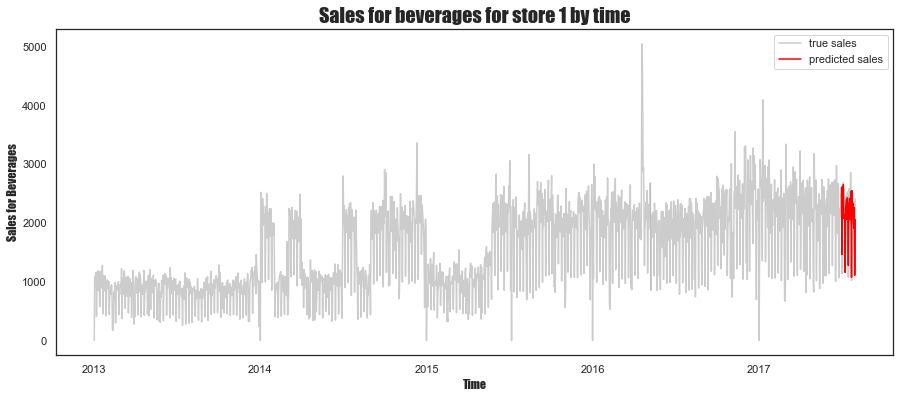

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_train_merged.loc[condition_train, 'date'], y_train_merged.loc[condition_train, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4)
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for Beverages", family="fantasy")
ax.set_title('Sales for beverages for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

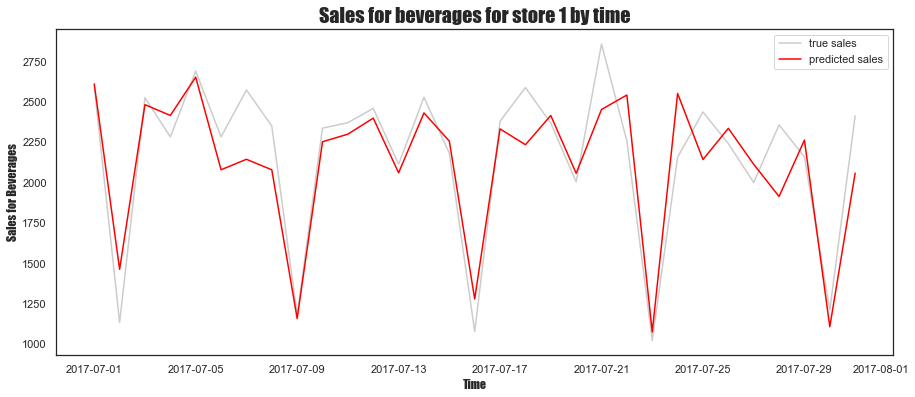

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for Beverages", family="fantasy")
ax.set_title('Sales for beverages for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

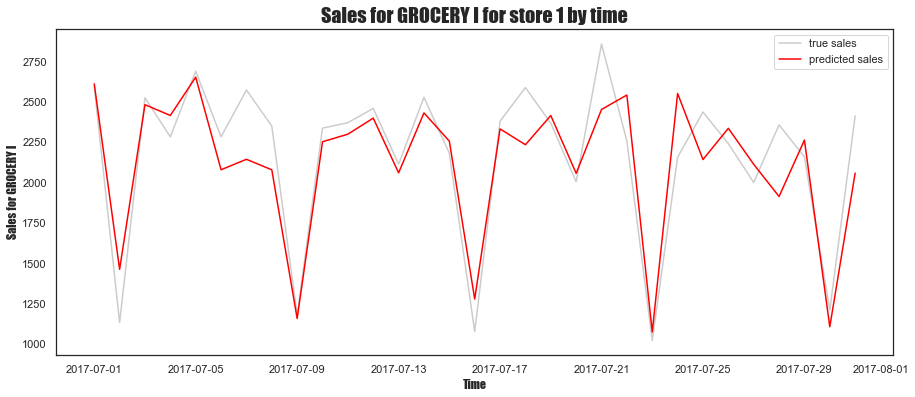

In [128]:
condition_grocery = X_test_selected[(X_test_selected['store_nbr']==1) & (X_test_selected['family']=='GROCERY I')].index.tolist()

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for GROCERY I", family="fantasy")
ax.set_title('Sales for GROCERY I for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

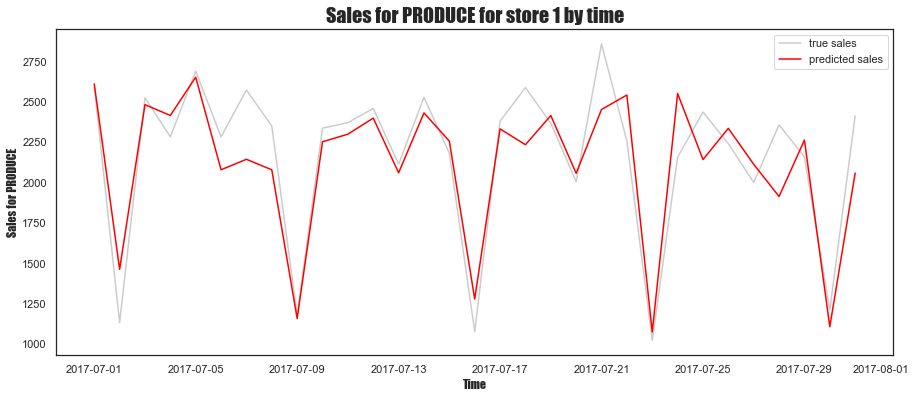

In [129]:
condition_grocery = X_test_selected[(X_test_selected['store_nbr']==1) & (X_test_selected['family']=='PRODUCE')].index.tolist()

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for PRODUCE", family="fantasy")
ax.set_title('Sales for PRODUCE for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

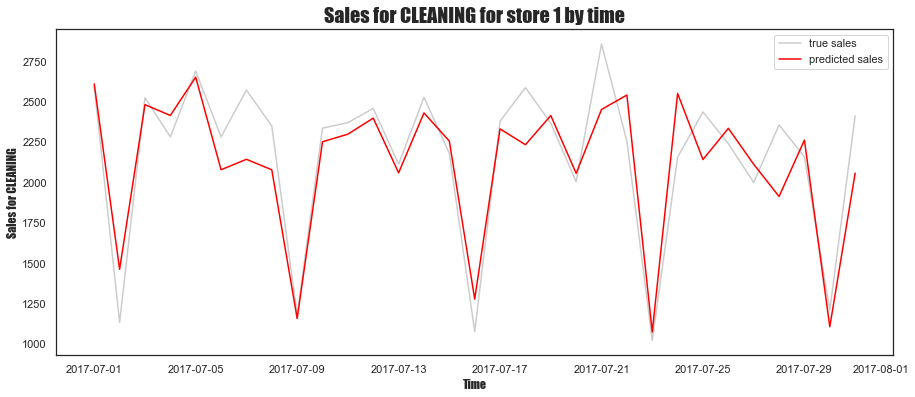

In [131]:
condition_grocery = X_test_selected[(X_test_selected['store_nbr']==1) & (X_test_selected['family']=='CLEANING')].index.tolist()

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for CLEANING", family="fantasy")
ax.set_title('Sales for CLEANING for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

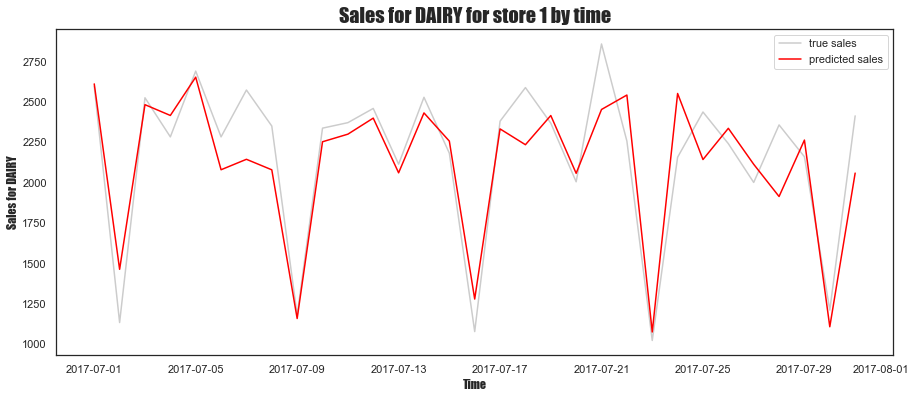

In [132]:
condition_grocery = X_test_selected[(X_test_selected['store_nbr']==1) & (X_test_selected['family']=='DAIRY')].index.tolist()

f, ax = plt.subplots(figsize=(15,6))

sns.set_theme(style="white")
sns.lineplot(y_test_merged.loc[condition, 'date'], y_test_merged.loc[condition, 'sales'], color="grey", alpha=.4, label='true sales')
sns.lineplot(y_test_merged.loc[condition, 'date'],y_test_merged.loc[condition, 'sales_pred'], color="red", label = 'predicted sales')

ax.set_xlabel("Time", family="fantasy")
ax.set_ylabel("Sales for DAIRY", family="fantasy")
ax.set_title('Sales for DAIRY for store 1 by time',fontsize= 20, family="fantasy")
ax.legend()

## 사후분석: SHAP

In [32]:
# 모델이 이렇게 예측한 이유를 알기 위하여
# SHAP Force Plot을 그려보겠습니다.

import shap
row = X_test_transformed_selected.iloc[[1]]
explainer = shap.TreeExplainer(best_model_GBR.named_steps['gradientboostingregressor'])
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

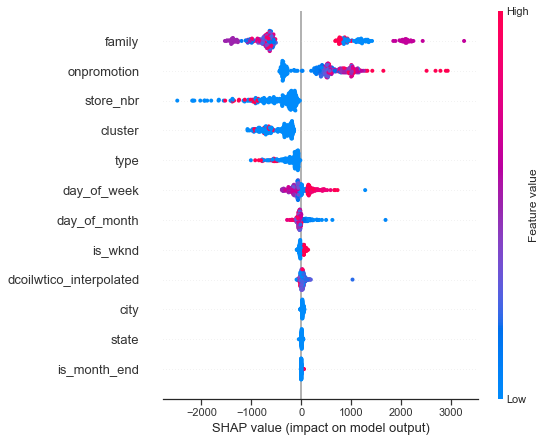

In [33]:
shap_values = explainer.shap_values(X_test_transformed_selected.iloc[:300])
shap.summary_plot(shap_values, X_test_transformed_selected.iloc[:300])

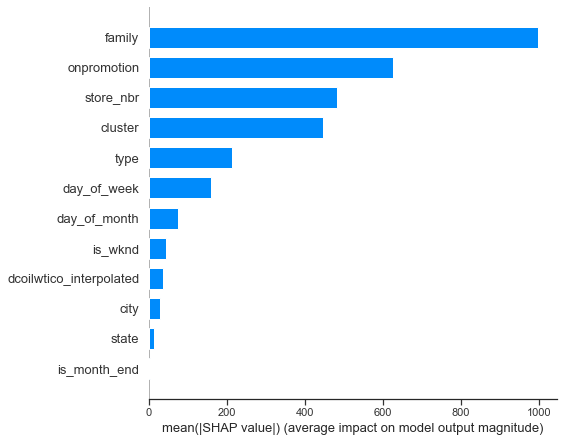

In [34]:
shap.summary_plot(shap_values, X_test_transformed_selected.iloc[:100], plot_type="bar")

In [35]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

## 사후분석: PDP

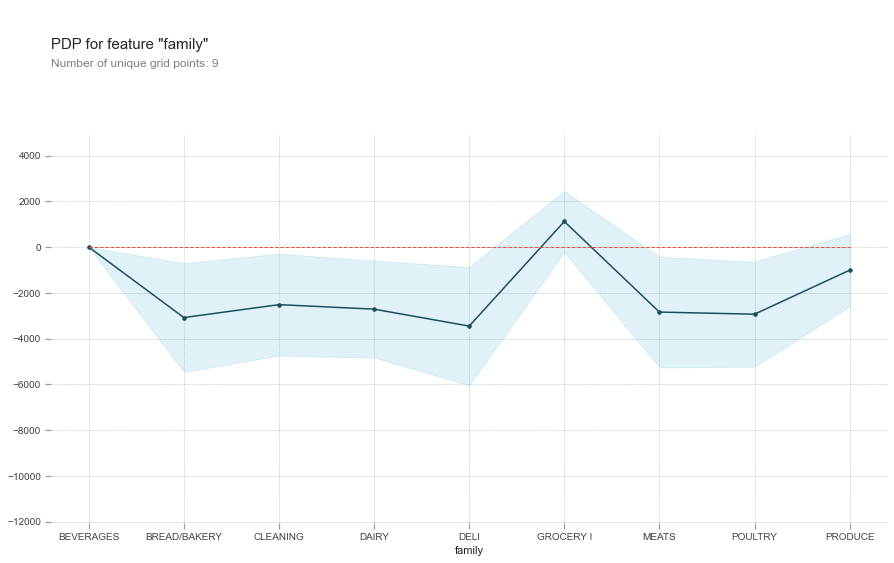

In [112]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot

encoder = best_model_GBR.named_steps['ordinalencoder']
feature = 'family'
pdp_dist = pdp.pdp_isolate(model=best_model_GBR.named_steps['gradientboostingregressor'], dataset=X_test_transformed_selected, model_features=X_test_transformed_selected.columns, feature=feature, num_grid_points=9)
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

In [77]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'onpromotion'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)

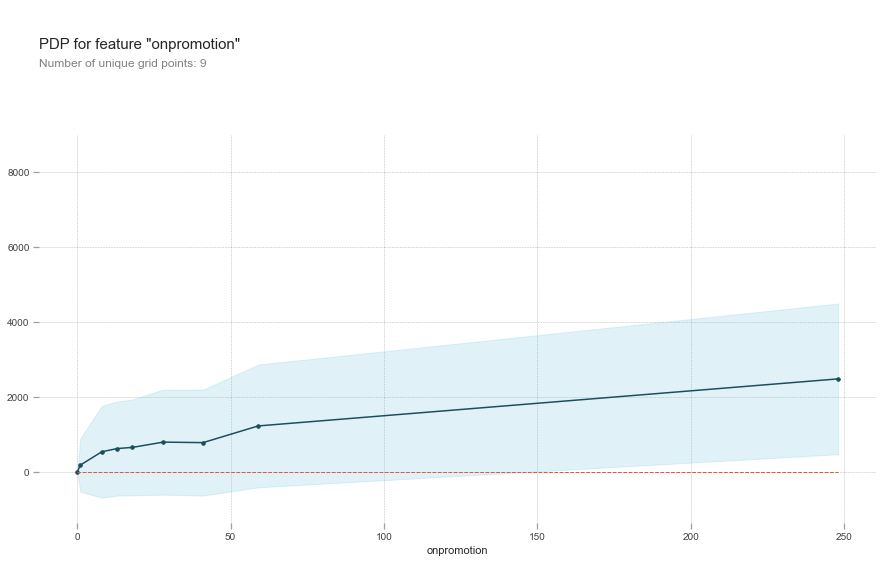

In [78]:
pdp_plot(isolated, feature_name=feature);

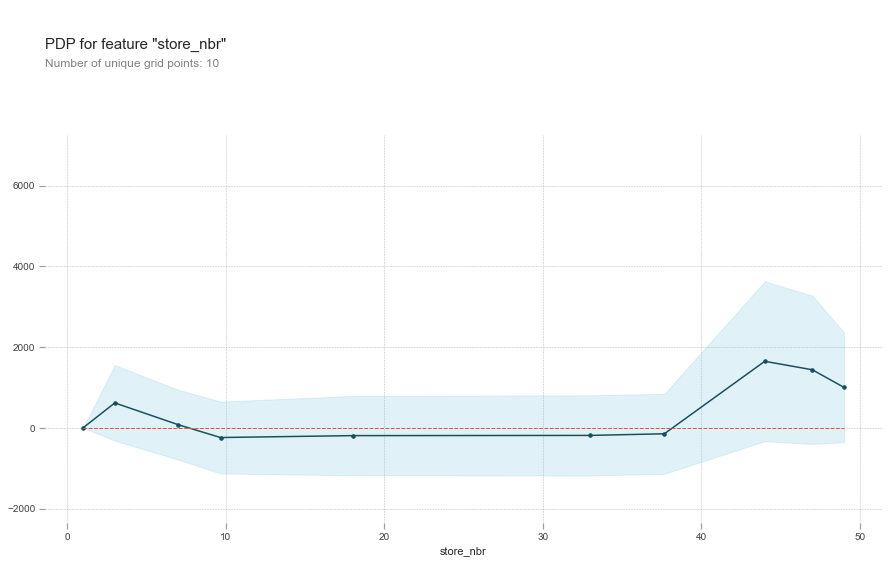

In [79]:
feature = 'store_nbr'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
pd.Series(df.store_nbr.unique()).sort_values()

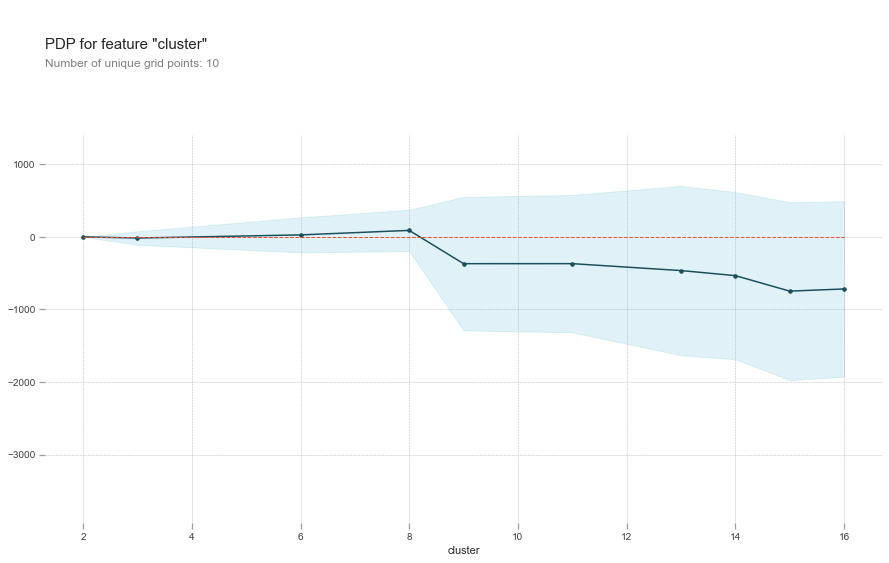

In [87]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'cluster'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

In [95]:
#3,7,8
df[df['cluster']== 8].store_nbr.value_counts()
#10, 19
df[df['cluster']== 15].store_nbr.value_counts()

10    15192
19    15192
Name: store_nbr, dtype: int64

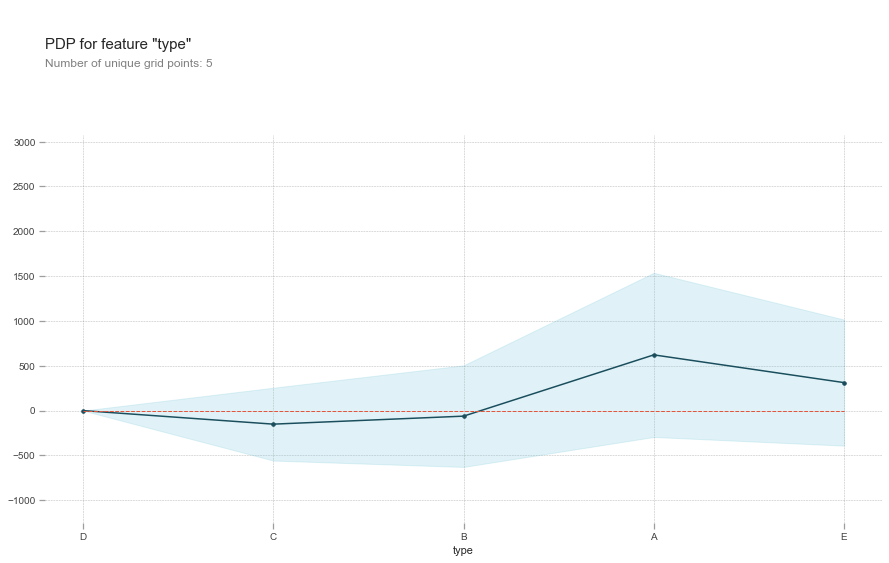

In [96]:
encoder = best_model_GBR.named_steps['ordinalencoder']
feature = 'type'
pdp_dist = pdp.pdp_isolate(model=best_model_GBR.named_steps['gradientboostingregressor'], dataset=X_test_transformed_selected, model_features=X_test_transformed_selected.columns, feature=feature)
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

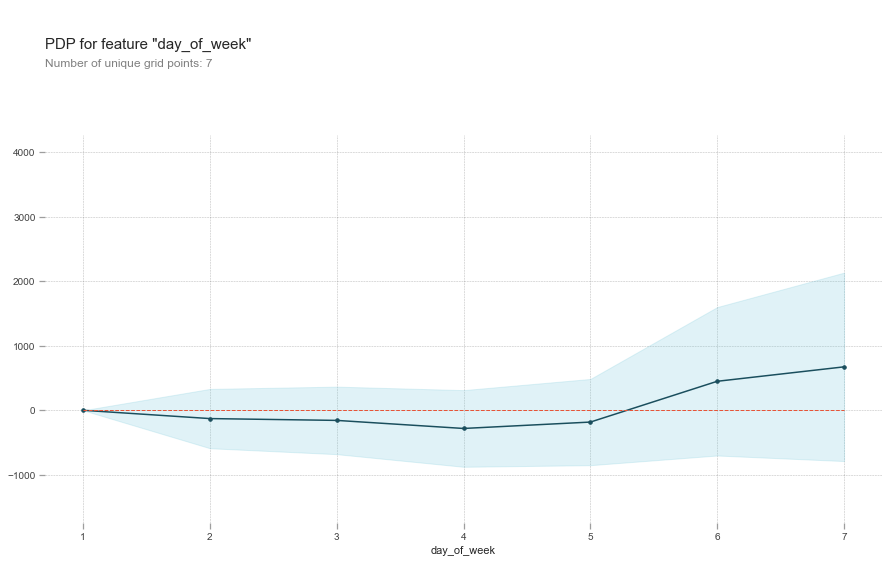

In [97]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'day_of_week'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

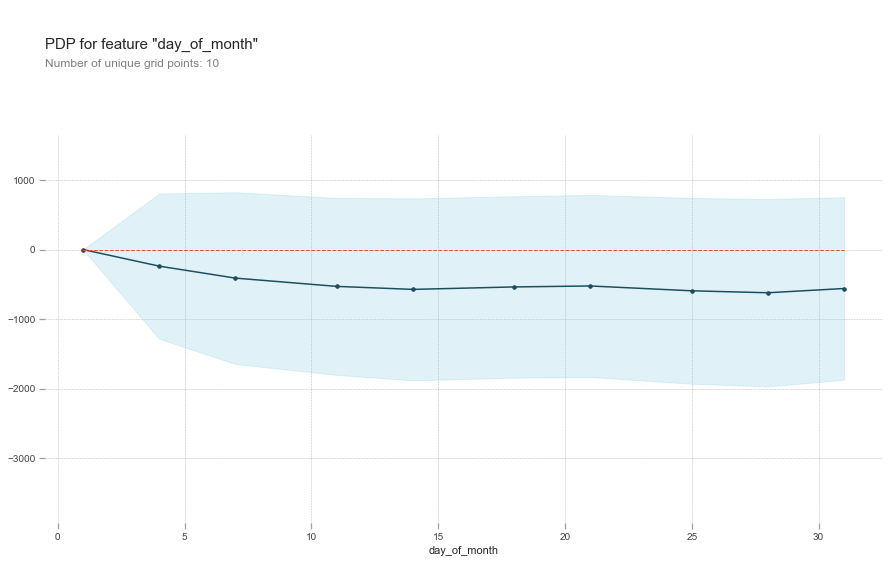

In [98]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'day_of_month'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

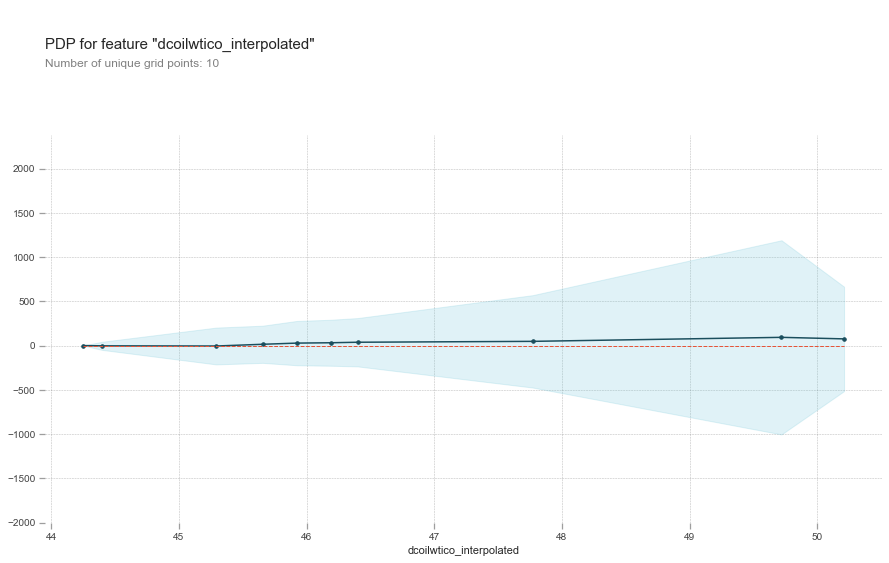

In [99]:
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot
feature = 'dcoilwtico_interpolated'
isolated = pdp_isolate(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature);

### Interaction PDP

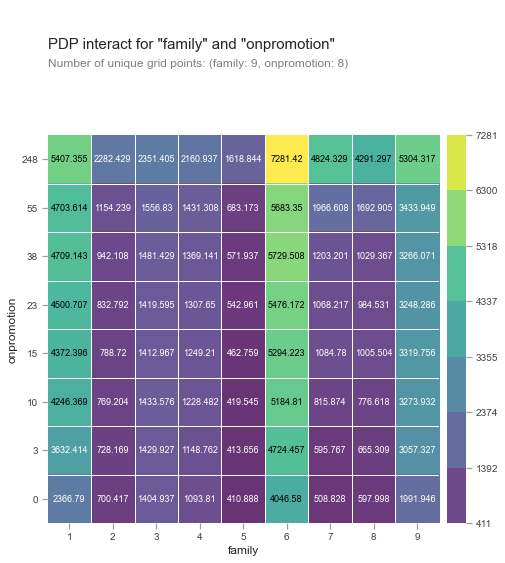

In [117]:
# 2D PDP
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['family', 'onpromotion']

interaction = pdp_interact(
    model=best_model_GBR.named_steps['gradientboostingregressor'], 
    dataset=X_test_transformed_selected, 
    model_features=X_test_transformed_selected.columns, 
    features=features,
    num_grid_points=[9, 9]
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

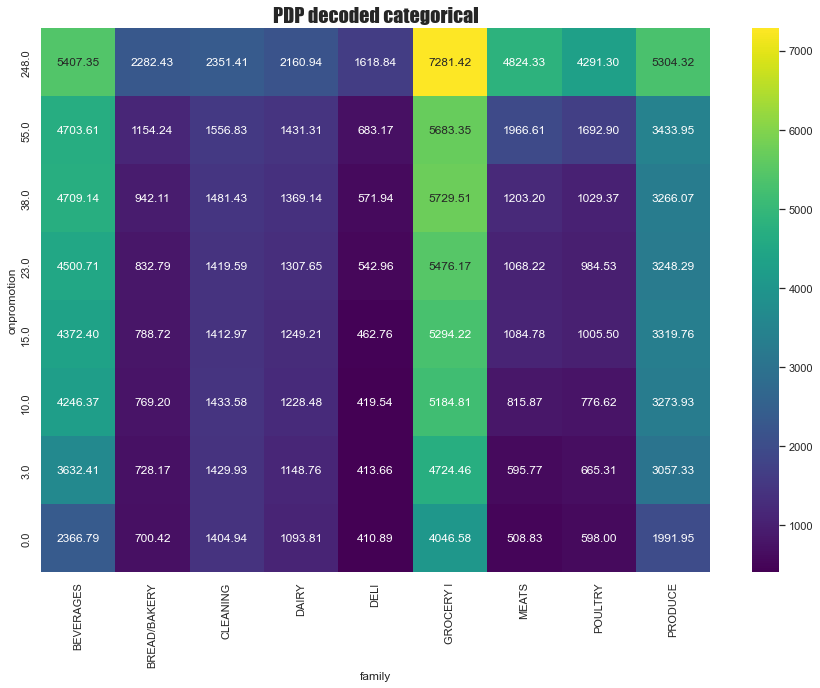

In [127]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
ax.set_title('PDP decoded categorical', fontsize= 20, family="fantasy");